In [1]:
# ============================================
# Internship Authenticity Detection Project
#  Data Loading, Cleaning & Exploration
# ============================================

#  Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score

from imblearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, ConfusionMatrixDisplay,make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV

import joblib
import warnings
warnings.filterwarnings('ignore')

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
df = pd.read_csv("../data/internships.csv")
print("Loaded data succesfully")
print(f"shape : {df.shape}")

Loaded data succesfully
shape : (17880, 18)


In [3]:
# print(df.head(3))
# print(df.info())
# print("\nMissing values per column: \n")
print(df.isnull().sum())


job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64


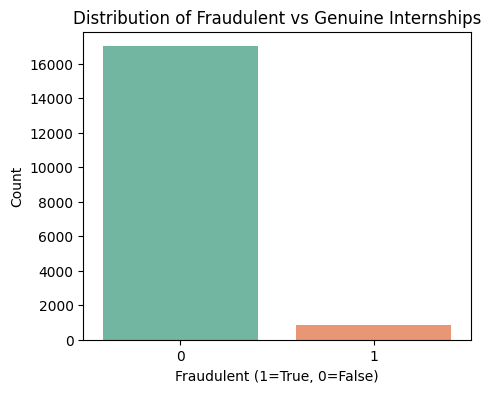

fraudulent
0    0.951566
1    0.048434
Name: proportion, dtype: float64


In [4]:
# Fraudulent column distribution
plt.figure(figsize=(5,4))
sns.countplot(x='fraudulent', data=df, palette='Set2')
plt.title("Distribution of Fraudulent vs Genuine Internships")
plt.xlabel("Fraudulent (1=True, 0=False)")
plt.ylabel("Count")
plt.show()

print(df['fraudulent'].value_counts(normalize=True))

In [5]:
# Step 5 — Handle Missing Values
# We’ll keep only the columns useful for text/NLP + numeric indicators.
# Keep relevant columns
text_cols = ['title', 'company_profile', 'description', 'requirements', 'benefits']
meta_cols = ['telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']

df = df[text_cols + meta_cols]

# Fill missing text fields with empty string
for col in text_cols:
    df[col] = df[col].fillna('')

print("✅ Missing text columns filled.")

✅ Missing text columns filled.


In [6]:
# Step 6 — Combine All Text Columns
# We’ll merge all text into one single “text” column for modeling.
df['text'] = df['title']+" "+df['company_profile']+" "+df['description']+" "+df['benefits']
df['text'] = df['text'].str.strip()

#Drop indivaidual columns to simplify
df = df[['text', 'telecommuting', 'has_company_logo', 'has_questions', 'fraudulent']]

print("Combined text columns Successfully!")
df.head(2)


Combined text columns Successfully!


,text,telecommuting,has_company_logo,has_questions,fraudulent
0,"Marketing Intern We're Food52, and we've creat...",0,1,0,0
1,Customer Service - Cloud Video Production 90 S...,0,1,0,0


In [7]:
# Step 7 — Text Cleaning Function
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Apply cleaning to a sample subset (to test speed )
df['clean_text'] = df['text'].apply(clean_text)
print("text cleaned successfully!")
df[['text','clean_text']].head(3)

text cleaned successfully!


,text,clean_text
0,"Marketing Intern We're Food52, and we've creat...",marketing intern food weve created groundbreak...
1,Customer Service - Cloud Video Production 90 S...,customer service cloud video production second...
2,Commissioning Machinery Assistant (CMA) Valor ...,commissioning machinery assistant cma valor se...


<h1>EDA</h1>

In [8]:

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Style setup
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10,5)

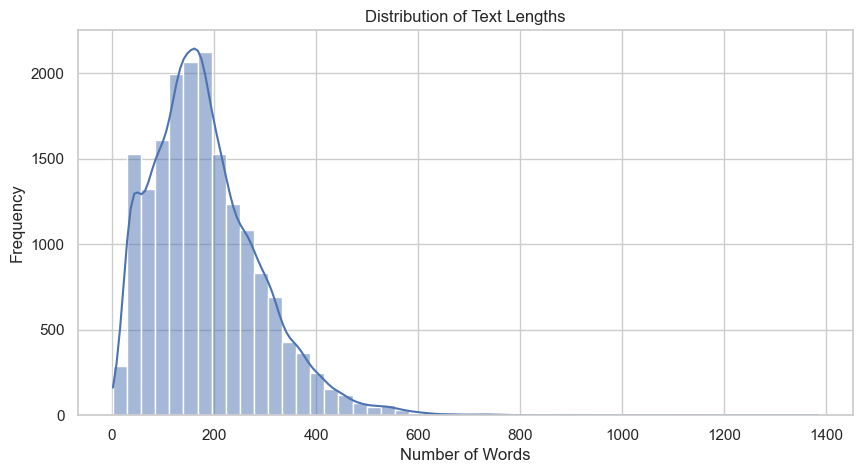

              count        mean         std  min    25%    50%     75%     max
fraudulent                                                                    
0           17014.0  185.836546  105.643084  4.0  112.0  171.0  245.00  1383.0
1             866.0  143.588915  107.576625  2.0   67.0  104.0  197.75   797.0


'Observation:\nFraudulent posts are often shorter, vague, or overly generic.\nGenuine ones tend to have longer and more descriptive content.'

In [9]:

df["text_length"] = df["clean_text"].apply(lambda x: len(str(x).split()))

sns.histplot(data=df, x="text_length", bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

print(df.groupby('fraudulent')['text_length'].describe())

'''Observation:
Fraudulent posts are often shorter, vague, or overly generic.
Genuine ones tend to have longer and more descriptive content.'''



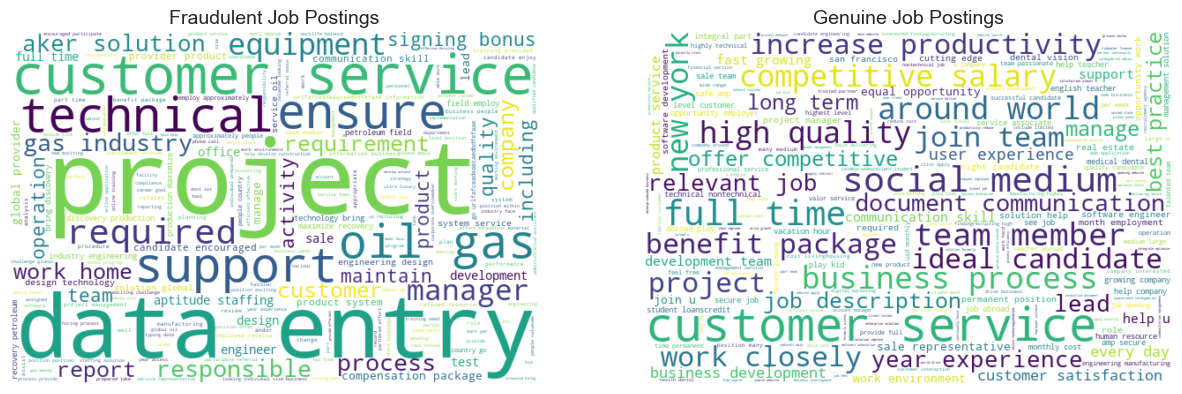

'\nObservation:\nFraudulent posts often contain exaggerated terms like "money", "urgent", "work from home", etc.\nGenuine ones include "experience", "skills", "team", "responsibilities", etc.\n'

In [10]:
# Generate word clouds for both classes
fraud_text = " ".join(df[df['fraudulent'] == 1]['clean_text'].astype(str))
genuine_text = " ".join(df[df['fraudulent'] == 0]['clean_text'].astype(str))

fig, ax = plt.subplots(1,2, figsize=(15,8))

wc1 = WordCloud(width=600, height=400, background_color='white').generate(fraud_text)
wc2 = WordCloud(width=600, height=400, background_color='white').generate(genuine_text)

ax[0].imshow(wc1, interpolation='bilinear')
ax[0].set_title("Fraudulent Job Postings", fontsize=14)
ax[0].axis('off')

ax[1].imshow(wc2, interpolation='bilinear')
ax[1].set_title("Genuine Job Postings", fontsize=14)
ax[1].axis('off')

plt.show()

'''
Observation:
Fraudulent posts often contain exaggerated terms like "money", "urgent", "work from home", etc.
Genuine ones include "experience", "skills", "team", "responsibilities", etc.
'''


<h2>Step 3: Feature Engineering
We’ll engineer some non-textual features that often correlate with fraudulence.</h2>

In [11]:
df['num_words'] = df['clean_text'].apply(lambda x: len(x.split()))
df['num_unique_words'] = df['clean_text'].apply(lambda x: len(set(x.split())))
df['num_chars'] = df['clean_text'].apply(lambda x: len(x))
df['avg_word_len'] = df['num_chars'] / (df['num_words'] + 1)
df['num_exclamations'] = df['clean_text'].apply(lambda x: x.count('!'))
df['num_question_marks'] = df['clean_text'].apply(lambda x: x.count('?'))
df['num_uppercase'] = df['clean_text'].apply(lambda x: sum(1 for w in x.split() if w.isupper()))

df[['num_words','num_unique_words','avg_word_len','num_exclamations','num_question_marks','num_uppercase']].head()


'''Why these features?
Fraudulent ads often:
Have more punctuation and uppercase.
Contain fewer unique words (repetitive).
Have short or flashy sentences.'''


'Why these features?\nFraudulent ads often:\nHave more punctuation and uppercase.\nContain fewer unique words (repetitive).\nHave short or flashy sentences.'

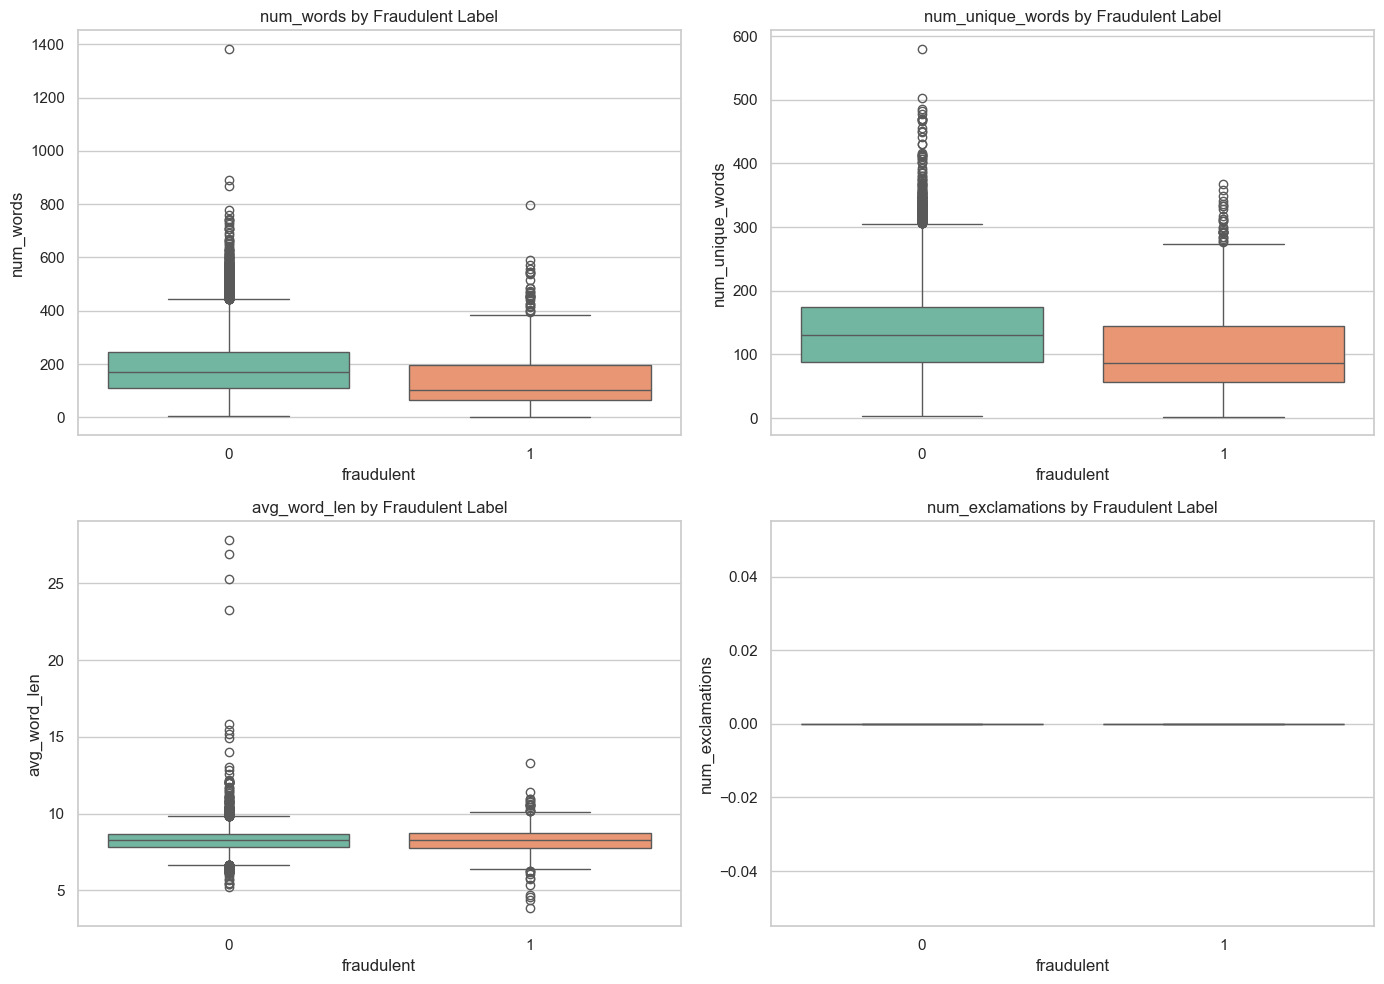

In [12]:
# Visualize Engineered Features
num_features = ['num_words', 'num_unique_words', 'avg_word_len', 'num_exclamations']
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

for i, feature in enumerate(num_features):
    sns.boxplot(data=df, x='fraudulent', y=feature, ax=axs[i//2, i%2], palette='Set2')
    axs[i//2, i%2].set_title(f"{feature} by Fraudulent Label")

plt.tight_layout()
plt.show()


In [13]:
'''Step 4: TF-IDF Vectorization
Now that textual cleaning is done, let’s extract meaningful features from text using TF-IDF.'''
tfidf = TfidfVectorizer(
    max_features=5000, 
    ngram_range=(1,2),   # unigrams + bigrams
    stop_words='english'
)

X_tfidf = tfidf.fit_transform(df['clean_text'])
print("TF-IDF Matrix Shape:", X_tfidf.shape)

'''
Explanation:
max_features=5000: keeps top 5000 most informative tokens.
ngram_range=(1,2): captures context like “work home” or “data analyst”.
Output X_tfidf will be used for model training.
'''


TF-IDF Matrix Shape: (17880, 5000)


'\nExplanation:\nmax_features=5000: keeps top 5000 most informative tokens.\nngram_range=(1,2): captures context like “work home” or “data analyst”.\nOutput X_tfidf will be used for model training.\n'

In [14]:
#Step 5: Combine Engineered Features + TF-IDF
from scipy.sparse import hstack

X_meta = df[['num_words', 'num_unique_words', 'avg_word_len', 'num_exclamations', 'num_question_marks', 'num_uppercase']].fillna(0)
X_final = hstack((X_tfidf, X_meta))

y = df['fraudulent']

print("Final Feature Shape:", X_final.shape)

'''Now you have:
X_final → Text + Numerical features
y → Labels (fraudulent or not)'''


Final Feature Shape: (17880, 5006)


'Now you have:\nX_final → Text + Numerical features\ny → Labels (fraudulent or not)'

<h3>Spliting , cross validation, Model Training, Evaluation & Hyperparameter Tuning</h3>

<h1>Step 1: Train-Test Split</h1>

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Extract only the cleaned text column
X_text = df['clean_text']
y = df['fraudulent']

# Vectorize
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X_text = tfidf.fit_transform(X_text)


In [16]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

# Define models in proper pipelines
pipelines = {
    "Logistic Regression": make_pipeline(
        SMOTE(random_state=42),
        LogisticRegression(max_iter=300, class_weight='balanced', random_state=42)
    ),
    "Random Forest": make_pipeline(
        SMOTE(random_state=42),
        RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    ),
    "SVM": make_pipeline(
        SMOTE(random_state=42),
        LinearSVC(max_iter=3000, class_weight='balanced', random_state=42)
    )
}

cv_results = {}

for name, pipe in pipelines.items():
    print(f"📊 {name}")
    
    # F1 score
    f1_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='f1')
    
    # ROC-AUC (skip for LinearSVC)
    if name != "SVM":
        auc_scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring='roc_auc')
        print(f"F1 (mean ± std): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
        print(f"ROC-AUC (mean ± std): {auc_scores.mean():.4f} ± {auc_scores.std():.4f}")
        cv_results[name] = {"F1 Mean": f1_scores.mean(), "ROC-AUC Mean": auc_scores.mean()}
    else:
        print(f"F1 (mean ± std): {f1_scores.mean():.4f} ± {f1_scores.std():.4f}")
        print("ROC-AUC: N/A (LinearSVC doesn’t support probability outputs)")
        cv_results[name] = {"F1 Mean": f1_scores.mean(), "ROC-AUC Mean": np.nan}
    
    print("-" * 60)


📊 Logistic Regression
F1 (mean ± std): 0.6842 ± 0.0225
ROC-AUC (mean ± std): 0.9711 ± 0.0110
------------------------------------------------------------
📊 Random Forest
F1 (mean ± std): 0.7844 ± 0.0228
ROC-AUC (mean ± std): 0.9788 ± 0.0082
------------------------------------------------------------
📊 SVM
F1 (mean ± std): 0.7801 ± 0.0215
ROC-AUC: N/A (LinearSVC doesn’t support probability outputs)
------------------------------------------------------------


In [17]:
# Train only on text features
# cv_scores_text = cross_val_score(
#     make_pipeline(SMOTE(random_state=42),
#                   LogisticRegression(max_iter=300, class_weight='balanced', random_state=42)),
#     X_text, y, cv=5, scoring='roc_auc'
# )
# print(cv_scores_text.mean())


In [18]:
# Quick sanity check: most informative words
# from sklearn.feature_extraction.text import TfidfVectorizer
# vectorizer = TfidfVectorizer(max_features=1000)
# X_tfidf = vectorizer.fit_transform(df['clean_text'])
# y = df['fraudulent']

# from sklearn.linear_model import LogisticRegression
# model = LogisticRegression(max_iter=300, class_weight='balanced')
# model.fit(X_tfidf, y)

# # Top words
# feature_names = np.array(vectorizer.get_feature_names_out())
# sorted_idx = np.argsort(model.coef_[0])[-20:]
# print(feature_names[sorted_idx])


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define pipeline
rf_pipe = make_pipeline(
    SMOTE(random_state=42),
    RandomForestClassifier(random_state=42, class_weight='balanced')
)

# Define parameter distributions (broader range than grid)
param_dist = {
    'randomforestclassifier__n_estimators': randint(100, 400),
    'randomforestclassifier__max_depth': [10, 20, 30, None],
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 5),
    'randomforestclassifier__max_features': ['sqrt', 'log2']
}

# Randomized Search
random_search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=20,                # number of random combinations to try
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

print("✅ Best Parameters Found:")
print(random_search.best_params_)
print(f"Best F1 Score: {random_search.best_score_:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
✅ Best Parameters Found:
{'randomforestclassifier__max_depth': None, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__n_estimators': 221}
Best F1 Score: 0.7944


In [23]:
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns

# Get best model
best_rf_rand = random_search.best_params_

# Predictions
y_pred = best_rf_rand.predict(X_test)
y_proba = best_rf_rand.predict_proba(X_test)[:, 1]

# 1️⃣ Classification Report
print("📋 Classification Report:")
print(classification_report(y_test, y_pred, digits=3))

# 2️⃣ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrBr', cbar=False)
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 3️⃣ ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc:.4f}")

# 4️⃣ ROC Curve
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Tuned Random Forest")
plt.show()



AttributeError: 'RandomizedSearchCV' object has no attribute 'best_params_'